<h1>4. Machine Learning Model </h1>

In [1]:
#import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm_notebook as tqdm
from sklearn import metrics
import gc
import warnings
import os
pd.set_option('display.max_columns', 200)

<h2> 4.1 Reading data from file and storing to variable </h2>

In [2]:
#loaing Data
train_df = pd.read_csv('train.csv') 
test_df = pd.read_csv('test.csv')

#Features for prediction(Indipendent variable)
features = [c for c in train_df.columns if c not in ['ID_code', 'target']] 
target = train_df['target']  #Labels

<h2> 5. LightGBM optimization</h2>

In [5]:
#saving all feature name to a variable as list
predictors = train_df.columns.values.tolist()[2:]

In [7]:
#StratifiedKFold with 2 fold .using for optimization
bayesian_tr_index, bayesian_val_index  = list(StratifiedKFold(n_splits=2, shuffle=True, random_state=1).split(train_df, target))[0]

<h2> 5.1 Setting paramaters to optimize </h2>

In [15]:
def LGB_bayesian(num_leaves,  min_data_in_leaf,  max_bin,  learning_rate,  lambda_l1, lambda_l2, min_gain_to_split, max_depth):
    
    num_leaves  =int(num_leaves)
    max_bin = int(max_bin)
    max_depth = int(max_depth)
    min_data_in_leaf= int(min_data_in_leaf)
    
    param = {'num_leaves': num_leaves,'max_bin': max_bin,'min_data_in_leaf': min_data_in_leaf,'learning_rate': learning_rate,
        'bagging_fraction': 1.0,'bagging_freq': 5, 'feature_fraction': 1, 'lambda_l1': lambda_l1, 'lambda_l2': lambda_l2,
        'min_gain_to_split': min_gain_to_split,'max_depth': max_depth,'save_binary': True, 'seed': 1337, 'feature_fraction_seed': 1337,
        'bagging_seed': 1337, 'drop_seed': 1337, 'objective': 'binary','boosting_type': 'gbdt','verbose': 1,
        'metric': 'auc','is_unbalance': True, 'boost_from_average': False,}
    
    # converting train data to lightgbm.basic.Dataset so that it can load faster
    xg_train = lgb.Dataset(train_df.iloc[bayesian_tr_index][predictors].values,
                           label=target.iloc[bayesian_tr_index].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )
    
    # converting validation data to lightgbm.basic.Dataset so that it can load faster
    xg_valid = lgb.Dataset(train_df.iloc[bayesian_val_index][predictors].values,
                           label=target.iloc[bayesian_val_index].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )   
    num_round = 5000 #iteration to happen
    #training lgb for getting paramaters
    clf = lgb.train(param, xg_train, num_round, valid_sets = [xg_valid], verbose_eval=250, early_stopping_rounds = 50)
    
    predictions = clf.predict(train_df.iloc[bayesian_val_index][predictors].values, num_iteration=clf.best_iteration)   
    
    #AUC is used metric we are trying to increase
    score = metrics.roc_auc_score(target.iloc[bayesian_val_index].values, predictions)
    
    return score

<h2> 5.2 Setting Range values for each paramaters to optimize</h2>

In [16]:
# Bounded region of parameter space,values between this range is sent to paramater for optimization
bounds_LGB = { 'num_leaves': (5, 20), 'min_data_in_leaf': (5, 20), 'max_bin':(30,60),
    'learning_rate': (0.01, 0.3), 'lambda_l1': (0, 3.0), 'lambda_l2': (0, 3.0), 
    'min_gain_to_split': (0, 1.0), 'max_depth':(3,15),
    }

<h2> 5.3 Passing the boundry values to the model</h2>

In [17]:
#put all of Bounded parameter in BayesianOptimization object
from bayes_opt import BayesianOptimization
LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=13)

#print the paramaters we set for optimization
print(LGB_BO.space.keys)

init_points = 10 #How many steps of random exploration you want to perform
n_iter = 8 # How many steps of bayesian optimization you want to perform

['lambda_l1', 'lambda_l2', 'learning_rate', 'max_bin', 'max_depth', 'min_data_in_leaf', 'min_gain_to_split', 'num_leaves']


In [18]:
#this is where the optimization starts. .maximize function starts the optimization process
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

|   iter    |  target   | lambda_l1 | lambda_l2 | learni... |  max_bin  | max_depth | min_da... | min_ga... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[171]	valid_0's auc: 0.877161
|  1        |  0.8772   |  2.333    |  0.7126   |  0.249    |  58.97    |  14.67    |  11.8     |  0.609    |  16.63    |
Training until validation scores don't improve for 50 rounds
[250]	valid_0's auc: 0.798269
[500]	valid_0's auc: 0.833448
[750]	valid_0's auc: 0.849342
[1000]	valid_0's auc: 0.859226
[1250]	valid_0's auc: 0.865696
[1500]	valid_0's auc: 0.870452
[1750]	valid_0's auc: 0.874011
[2000]	valid_0's auc: 0.877098
[2250]	valid_0's auc: 0.87936
[2500]	valid_0's auc: 0.881142
[2750]	valid_0's auc: 0.88267
[3000]	valid_0's auc: 0.88388
[3250]	valid_0's auc: 0.884884
[3500]	valid_0's auc: 0.885694
[3750]	valid_0's au

In [19]:
#display all Iterations auc score with the paramates which with which the auc is achived
for i, res in enumerate(LGB_BO.res):
    print("Iteration {}: \n\t{}".format(i, res))

Iteration 0: 
	{'target': 0.8771608428435963, 'params': {'lambda_l1': 2.3331072317214607, 'lambda_l2': 0.7126236601047369, 'learning_rate': 0.24904077447179687, 'max_bin': 58.97247594128999, 'max_depth': 14.67121336685872, 'min_data_in_leaf': 11.801738711259683, 'min_gain_to_split': 0.6090424627612779, 'num_leaves': 16.6328977190727}}
Iteration 1: 
	{'target': 0.8879871548999458, 'params': {'lambda_l1': 1.9248400342772074, 'lambda_l2': 2.1660546885508416, 'learning_rate': 0.02016059198941682, 'max_bin': 38.95348412667538, 'max_depth': 3.702149902584897, 'min_data_in_leaf': 17.855914138807982, 'min_gain_to_split': 0.3728540278748075, 'num_leaves': 15.197719273671455}}
Iteration 2: 
	{'target': 0.8891023129642595, 'params': {'lambda_l1': 0.7688398479798904, 'lambda_l2': 1.0427436454574759, 'learning_rate': 0.01272970332348113, 'max_bin': 40.7500134811491, 'max_depth': 14.389130180138524, 'min_data_in_leaf': 8.268485136975334, 'min_gain_to_split': 0.3193913663803646, 'num_leaves': 18.7665

In [20]:
print("Max AUC we got",LGB_BO.max['target'])
print("Paramaters which gave maximum AUC",LGB_BO.max['params'])

Max AUC we got 0.8894812512661345
Paramaters which gave maximum AUC {'lambda_l1': 3.0, 'lambda_l2': 3.0, 'learning_rate': 0.01, 'max_bin': 44.69592944946842, 'max_depth': 15.0, 'min_data_in_leaf': 19.99999993628565, 'min_gain_to_split': 5.183696042004484e-08, 'num_leaves': 20.0}


<h2> 6. Training the model with best Paramaters which gave best AUC</h2>

In [21]:
#Setting best paramaters
param={'max_bin' : int(np.round(LGB_BO.max['params']['max_bin'])),
        'lambda_l1': LGB_BO.max['params']['lambda_l1'], 
        'lambda_l2': LGB_BO.max['params']['lambda_l2'], 
        'learning_rate': LGB_BO.max['params']['learning_rate'], 
        'max_depth': int(np.round(LGB_BO.max['params']['max_depth'])), 
        'min_data_in_leaf': int(np.round(LGB_BO.max['params']['min_data_in_leaf'])), 
        'min_gain_to_split': LGB_BO.max['params']['min_gain_to_split'], 
        'num_leaves': int(np.round(LGB_BO.max['params']['num_leaves'])),
        'verbosity': 1,
        'objective': 'binary',}

In [23]:
#training and predicting lgb model with best param which we got through bayes optimization
folds = StratifiedKFold(n_splits=5, shuffle=False, random_state=99999)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    
    #converting train data to lightgbm.basic.Dataset so that it can load faster
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][predictors], label=target.iloc[trn_idx])

    #converting validation data to lightgbm.basic.Dataset so that it can load faster
    val_data = lgb.Dataset(train_df.iloc[val_idx][predictors], label=target.iloc[val_idx])

    clf = lgb.train(param, trn_data, 12000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 50)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][predictors], num_iteration=clf.best_iteration)
    predictions += clf.predict(test_df[predictors], num_iteration=clf.best_iteration) / folds.n_splits
    
    
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))
sub = pd.DataFrame({"ID_code": test_df.ID_code.values})
sub["target"] = predictions
sub.to_csv("without_responce_code_aai.csv", index=False)

C:\Users\prassena.k\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Fold 0
Training until validation scores don't improve for 50 rounds
[1000]	training's binary_logloss: 0.22694	valid_1's binary_logloss: 0.247468
[2000]	training's binary_logloss: 0.193758	valid_1's binary_logloss: 0.226734
[3000]	training's binary_logloss: 0.17406	valid_1's binary_logloss: 0.216634
[4000]	training's binary_logloss: 0.160424	valid_1's binary_logloss: 0.211516
[5000]	training's binary_logloss: 0.150655	valid_1's binary_logloss: 0.209743
[6000]	training's binary_logloss: 0.142831	valid_1's binary_logloss: 0.209213
Early stopping, best iteration is:
[6358]	training's binary_logloss: 0.140262	valid_1's binary_logloss: 0.209121
Fold 1
Training until validation scores don't improve for 50 rounds
[1000]	training's binary_logloss: 0.226988	valid_1's binary_logloss: 0.24741
[2000]	training's binary_logloss: 0.193688	valid_1's binary_logloss: 0.22702
[3000]	training's binary_logloss: 0.17389	valid_1's binary_logloss: 0.217423
[4000]	training's binary_logloss: 0.16011	valid_1's bi

<h2> 7. Finding Threshold </h2>

In [24]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [25]:
from sklearn.metrics import roc_curve
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(target, oof)

the maximum value of tpr*(1-fpr) 0.6597140587368959 for threshold 0.104


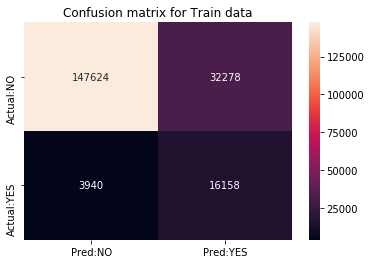

In [27]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
import matplotlib.pyplot as plt
heatmap(confusion_matrix(target, predict(oof, tr_thresholds1, train_fpr1, train_tpr1)),annot=True, fmt="d",xticklabels=["Pred:NO","Pred:YES"],yticklabels=["Actual:NO","Actual:YES"])
plt.title("Confusion matrix for Train data")
plt.show()